In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
import pandas_ta as ta

import datetime

start = '2010-01-01'
end = '2023-03-01'

gold_stock = yf.download('GC=F', start=start, end=end, interval='1d', auto_adjust=True)
gold_stock.to_csv('gold_stock_data.csv')


[*********************100%***********************]  1 of 1 completed


In [2]:
gold_stock['RSI'] = ta.rsi(gold_stock.Close, length=15)
gold_stock['EMAF'] = ta.ema(gold_stock.Close, length=20)
gold_stock['EMAM'] = ta.ema(gold_stock.Close, length=100)
gold_stock['EMAS'] = ta.ema(gold_stock.Close, length=150)
gold_stock['Target_Next'] = gold_stock['Close'].shift(-1)


gold_stock.dropna(inplace=True)
gold_stock.reset_index(inplace=True)
gold_stock.drop(['Volume', 'Date'], axis = 1, inplace=True)

gold_stock

,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,Target_Next
0,1203.300049,1211.000000,1195.300049,1203.400024,53.553251,1191.900042,1180.326940,1160.848666,1200.699951
1,1205.800049,1209.500000,1199.800049,1200.699951,52.289935,1192.738129,1180.730366,1161.376498,1196.199951
2,1196.199951,1206.500000,1191.000000,1196.199951,50.176324,1193.067826,1181.036695,1161.837736,1197.500000
3,1197.500000,1208.000000,1193.000000,1197.500000,50.792001,1193.489938,1181.362701,1162.310083,1214.800049
4,1214.800049,1215.500000,1199.000000,1214.800049,58.163034,1195.519472,1182.024827,1163.005315,1214.900024
...,...,...,...,...,...,...,...,...,...
3155,1842.599976,1843.000000,1833.000000,1833.000000,37.291432,1867.010497,1817.719878,1804.916682,1832.000000
3156,1835.699951,1836.199951,1825.099976,1832.000000,37.016030,1863.676164,1818.002653,1805.275401,1818.000000
3157,1826.400024,1827.500000,1818.000000,1818.000000,33.324454,1859.326053,1818.002600,1805.443939,1808.800049
3158,1808.800049,1808.800049,1808.800049,1808.800049,31.138032,1854.514052,1817.820371,1805.488390,1817.000000


In [3]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
gold_stock = sc.fit_transform(gold_stock)

gold_stock

array([[0.14961504, 0.14752475, 0.15003028, ..., 0.09806156, 0.05793882,
        0.14979505],
       [0.15211529, 0.1460396 , 0.15455835, ..., 0.09857445, 0.05864007,
        0.1452982 ],
       [0.14251423, 0.14306931, 0.1457034 , ..., 0.09896389, 0.05925284,
        0.14659734],
       ...,
       [0.77277724, 0.75792079, 0.77661502, ..., 0.90875255, 0.91431177,
        0.75746981],
       [0.7551755 , 0.73940599, 0.76735768, ..., 0.90852088, 0.91437083,
        0.76566402],
       [0.75797571, 0.7480198 , 0.76745828, ..., 0.90850023, 0.91457339,
        0.77755572]])

In [4]:
X = []

backCandles = 30

for j in range(8):
    X.append([])
    for i in range(backCandles, gold_stock.shape[0]):
        X[j].append(gold_stock[i-backCandles:i,j])

X=np.moveaxis(X, [0], [2])
X, yi = np.array(X), np.array(gold_stock[backCandles:,-1])
y = np.reshape(yi, (len(yi),1))

print(X.shape)
print(y.shape)



(3130, 30, 8)
(3130, 1)


In [5]:
split = int(len(X)*0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, SimpleRNN, Conv1D, MaxPool1D, Flatten
from keras.optimizers import Adam

LSTMmodel = Sequential()
LSTMmodel.add(LSTM(150, activation='relu')) #LSTM layer
LSTMmodel.add(Dense(64))
LSTMmodel.add(Dense(1))

LSTMmodel.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

LSTMmodel.fit(X_train, y_train, epochs=10)


Epoch 1/10
79/79 [==============================] - 4s 24ms/step - loss: 0.0064 - mean_absolute_error: 0.0432
Epoch 2/10
79/79 [==============================] - 2s 21ms/step - loss: 6.9688e-04 - mean_absolute_error: 0.0186
Epoch 3/10
79/79 [==============================] - 2s 20ms/step - loss: 6.7575e-04 - mean_absolute_error: 0.0185
Epoch 4/10
79/79 [==============================] - 2s 22ms/step - loss: 6.3719e-04 - mean_absolute_error: 0.0177
Epoch 5/10
79/79 [==============================] - 2s 20ms/step - loss: 7.8654e-04 - mean_absolute_error: 0.0203
Epoch 6/10
79/79 [==============================] - 2s 22ms/step - loss: 6.1156e-04 - mean_absolute_error: 0.0175
Epoch 7/10
79/79 [==============================] - 2s 22ms/step - loss: 6.3869e-04 - mean_absolute_error: 0.0181
Epoch 8/10
79/79 [==============================] - 2s 19ms/step - loss: 6.1607e-04 - mean_absolute_error: 0.0175
Epoch 9/10
79/79 [==============================] - 2s 22ms/step - loss: 6.1673e-04 - mean_a

20/20 [==============================] - 0s 9ms/step


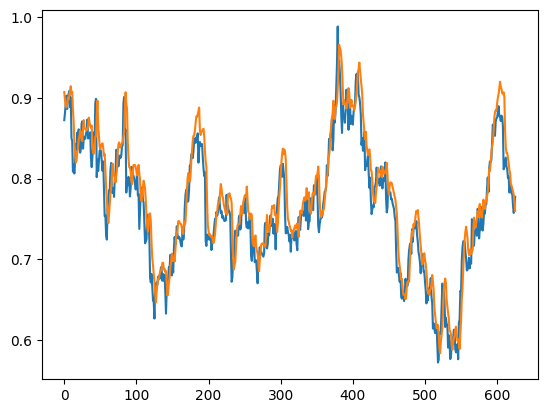

In [16]:
import matplotlib.pyplot as plt

y_preds = LSTMmodel.predict(X_test).flatten()

plt.plot(y_test)
plt.plot(y_preds)

In [20]:
CNNmodel = Sequential()
CNNmodel.add(Conv1D(150,kernel_size=2, input_shape=(backCandles,8), activation="relu"))
CNNmodel.add(MaxPool1D(pool_size=2))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(64))
CNNmodel.add(Dense(1))

CNNmodel.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
CNNmodel.summary()
CNNmodel.fit(X_train, y_train, epochs=50, batch_size=32)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 29, 150)           2550      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 150)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2100)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                134464    
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 137,079
Trainable params: 137,079
Non-trainable params: 0
________________________________________________

20/20 [==============================] - 0s 2ms/step


(626,)

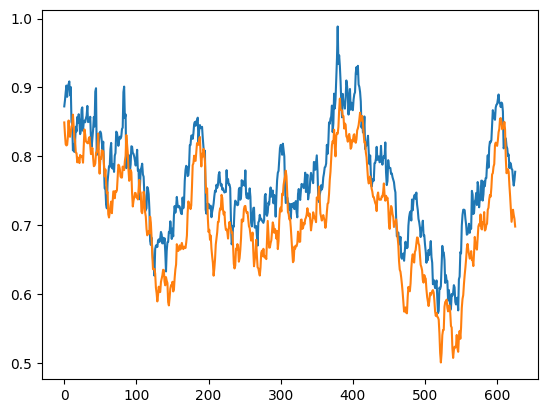

In [18]:
y_preds = CNNmodel.predict(X_test).flatten()

plt.plot(y_test)
plt.plot(y_preds)

y_preds.shape

In [21]:
LSTMscore = LSTMmodel.evaluate(X_test,y_test, verbose=0)
RNNscore = CNNmodel.evaluate(X_test, y_test, verbose=0)

print("LSTM MSE:" ,LSTMscore[0])
print("LSTM MAE:", LSTMscore[1])
print("CNN MSE:" ,RNNscore[0])
print("CNN MAE:", RNNscore[1])

LSTM MSE: 0.0008475930662825704
LSTM MAE: 0.022423580288887024
CNN MSE: 0.007212574128061533
CNN MAE: 0.07890408486127853
